In [63]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [85]:
df_raw = pd.read_csv('cl4.csv')

In [134]:
# df = df_raw[df_raw['REG_YYMM'].isin([202001, 202002, 202003])]
# df.head()

In [135]:
df = df_raw
df.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
0,201901,경기,건강보조식품 소매업,10s,1,1,4,12450,4,0
1,201901,경기,건강보조식품 소매업,10s,2,1,4,18600,5,0
2,201901,경기,건강보조식품 소매업,20s,1,1,65,4192670,81,0
3,201901,경기,건강보조식품 소매업,20s,1,2,6,298800,6,0
4,201901,경기,건강보조식품 소매업,20s,2,1,122,6822350,134,0


# Data Preprocessing

In [136]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [137]:
df['year'] = df['REG_YYMM'].apply(lambda x: grap_year(x))
df['month'] = df['REG_YYMM'].apply(lambda x: grap_month(x))
df = df.drop(['REG_YYMM'], axis=1)

In [138]:
def make_season(data):
    if data in [12, 1, 2]:
        return 'Winter'
    elif data in [3, 4, 5]:
        return 'Spring'
    elif data in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [139]:
df['Season'] = df['month'].apply(lambda x: make_season(x))

In [140]:
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV,year,month,Season
0,경기,건강보조식품 소매업,10s,1,1,4,12450,4,0,2019,1,Winter
1,경기,건강보조식품 소매업,10s,2,1,4,18600,5,0,2019,1,Winter
2,경기,건강보조식품 소매업,20s,1,1,65,4192670,81,0,2019,1,Winter
3,경기,건강보조식품 소매업,20s,1,2,6,298800,6,0,2019,1,Winter
4,경기,건강보조식품 소매업,20s,2,1,122,6822350,134,0,2019,1,Winter


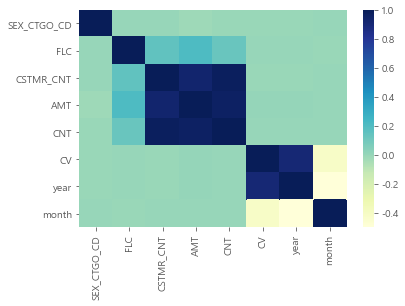

In [141]:
sns.heatmap(df.corr(),cmap='YlGnBu',fmt='.1g')

# Label Encoding

In [142]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630 entries, 0 to 4629
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CARD_SIDO_NM  4630 non-null   int32
 1   STD_CLSS_NM   4630 non-null   int32
 2   AGE           4630 non-null   int32
 3   SEX_CTGO_CD   4630 non-null   int64
 4   FLC           4630 non-null   int64
 5   CSTMR_CNT     4630 non-null   int64
 6   AMT           4630 non-null   int64
 7   CNT           4630 non-null   int64
 8   CV            4630 non-null   int64
 9   year          4630 non-null   int64
 10  month         4630 non-null   int64
 11  Season        4630 non-null   int32
dtypes: int32(4), int64(8)
memory usage: 361.8 KB


In [144]:
df.STD_CLSS_NM.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [145]:
df['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

# Preprocessing

In [146]:
# 변수명 지정
X_cols = list(df.columns)
X_cols.remove('AMT')

In [147]:
X = df.drop(['AMT'], axis=1)
y = np.log1p(df['AMT'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [148]:
X = df.drop(['AMT'], axis=1)
y = df[['month', 'AMT']]
y['AMT'] = np.log1p(df['AMT'])
X_train, X_test, y_train, y_test = X[X['month'].isin([1,2])], X[X['month']==3], y[y['month'].isin([1,2])]['AMT'], y[y['month']==3]['AMT']

# Light Gradient Boosting Machine

In [149]:
import lightgbm as lgb

In [150]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

In [151]:
params = {
            'learning_rate' : 0.1,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1        }

In [152]:
model = lgb.train(params,
                  train_ds,
                  5000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.29885
[200]	valid_0's rmse: 0.294587
[300]	valid_0's rmse: 0.294219
[400]	valid_0's rmse: 0.293772
[500]	valid_0's rmse: 0.295672
Early stopping, best iteration is:
[400]	valid_0's rmse: 0.293772


# Template

In [153]:
X.columns

Index(['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT',
       'CNT', 'CV', 'year', 'month', 'Season'],
      dtype='object')

In [154]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
AGEs          = df['AGE'].unique()
SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
FLCs          = df['FLC'].unique()
Seasons = df['Season'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for AGE in AGEs:
            for SEX_CTGO_CD in SEX_CTGO_CDs:
                for FLC in FLCs:
                    for year in years:
                        for month in months:
                            for Season in Seasons:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, AGE, SEX_CTGO_CD, FLC, year, month, Season])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'Season'])

In [155]:
temp

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,year,month,Season
0,0,0,0,1,1,2020,4,3
1,0,0,0,1,1,2020,4,1
2,0,0,0,1,1,2020,4,2
3,0,0,0,1,1,2020,4,0
4,0,0,0,1,1,2020,7,3
...,...,...,...,...,...,...,...,...
6715,0,11,6,2,5,2020,4,0
6716,0,11,6,2,5,2020,7,3
6717,0,11,6,2,5,2020,7,1
6718,0,11,6,2,5,2020,7,2


In [156]:
df2 = df[(df['year']==2020) & (df['month']==2)]
df3 = df[(df['year']==2020) & (df['month']==3)]
df4 = pd.concat([df2, df3], axis=0)

In [157]:
df4.drop(['AMT', 'year', 'month', 'Season'], axis=1, inplace=True)

In [158]:
temp = pd.merge(temp, df4, on=['CARD_SIDO_NM','STD_CLSS_NM','AGE','SEX_CTGO_CD','FLC'])

In [159]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

In [160]:
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [161]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [162]:
v = pd.merge(temp[temp['REG_YYMM']==202004],df_raw[df_raw['REG_YYMM']==202003].groupby(['STD_CLSS_NM'])[['AMT']].sum().reset_index(), on=['STD_CLSS_NM'])
v = v.drop(['REG_YYMM', 'CARD_SIDO_NM'], axis=1)
v = v.rename(columns={'AMT_x' : '4월', 'AMT_y' : '3월'})
v['3월 대비 증감률'] = (v['4월'] - v['3월']) / v['3월'] * 100
v

,STD_CLSS_NM,4월,3월,3월 대비 증감률
0,건강보조식품 소매업,1.979646e+10,1284597187,1441.063940
1,골프장 운영업,1.906444e+10,14282870436,33.477654
2,과실 및 채소 소매업,6.273611e+09,8114936000,-22.690571
3,그외 기타 종합 소매업,1.140198e+10,9593389882,18.852503
4,기타 수상오락 서비스업,5.301558e+09,46137060,11390.887196
5,기타음식료품위주종합소매업,1.054602e+10,21624337619,-51.230766
6,빵 및 과자류 소매업,6.407446e+09,14820214723,-56.765498
7,수산물 소매업,9.297794e+09,4093272663,127.148164
8,슈퍼마켓,1.044524e+10,143081115973,-92.699777
9,스포츠 및 레크레이션 용품 임대업,2.774879e+10,11219658475,147.322942


In [163]:
temp.to_csv('./template4.csv',index=False, encoding='utf-8-sig')